# 1 线性回归的从零实现
我们将从零开始实现整个算法，包括数据流水线、模型、
损失函数和小批量随机梯度下降优化器

In [61]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

#### 根据带有噪声的线性模型构造一个人工数据集。我们使用线性回归模型参数w = [2,-3.4]T, b=4.2和噪声项
#### 生成数据集及其标签   y = Xw + b + 噪声项
#### 两个变量即X是两行一列

In [62]:
def synthetic_data(w,b,num_examples):
    """生成 y= Xw + b + 噪声"""
    # X这里是矩阵，生成一个服从均值为0，标准差为1的正态分布的随机数，形状大小为(num_examples,len(w))
    X = torch.normal(0,1,(num_examples,len(w)))
    # matmul是矩阵进行乘法
    y = torch.matmul(X,w)+b
    y += torch.normal(0,0.01,y.shape)
    # reshape中-1表示自动计算，1表示固定，即列向量为1
    return X, y.reshape((-1,1))

true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b,1000)

#### features中每一行都包含一个二维数据样本，labels中每一行都包含一维标签值(一个标量)

In [63]:
print('features:',features[0],'\nlabel:',labels[0])

features: tensor([-0.5579,  0.8237]) 
label: tensor([0.2774])


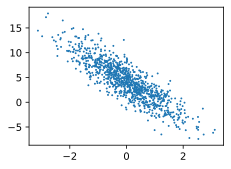

In [64]:
d2l.set_figsize()
d2l.plt.scatter(features[:,(1)].detach().numpy(),
               labels.detach().numpy(),1);

#### 定义一个data_iter函数，该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量

In [65]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 通过shuffle随机打乱，将样本随机读取
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        batch_indices = torch.tensor(indices[i:min(i+batch_size,num_examples)])
        print(batch_indices)
        # 这个表达式表示从特征（features）中选择与batch_indices张量中指定索引相对应的批次特征数据
        yield features[batch_indices],labels[batch_indices]

batch_size = 10
for X,y in data_iter(batch_size,features,labels):
    print(X, '\n',y)
    break

tensor([615, 507, 374, 245, 500, 925, 725, 361, 312, 104])
tensor([[ 0.7644,  1.7893],
        [ 0.4489,  0.7567],
        [ 0.8929, -0.6931],
        [-0.6481, -0.1653],
        [-0.3872, -1.5352],
        [-0.0769, -1.5447],
        [ 1.0239, -1.3656],
        [-0.0963, -0.6038],
        [-0.0517,  0.2157],
        [-1.4474,  0.6339]]) 
 tensor([[-0.3420],
        [ 2.5220],
        [ 8.3388],
        [ 3.4626],
        [ 8.6453],
        [ 9.3001],
        [10.8914],
        [ 6.0632],
        [ 3.3527],
        [-0.8509]])


#### 定义初始化模型参数

In [66]:
w = torch.normal(0,0.01,size=(2,1),requires_grad=True)
b = torch.zeros(1,requires_grad=True)
print(w)
print(b)

tensor([[ 0.0158],
        [-0.0024]], requires_grad=True)
tensor([0.], requires_grad=True)


#### 定义模型

In [67]:
def linreg(X,w,b):
    return torch.matmul(X,w)+b

#### 定义损失函数

In [68]:
# y_hat是预测值，y是真实值
def squared_loss(y_hat,y):
    # 均方损失
    return (y_hat - y.reshape(y_hat.shape))**2/2

#### 定义优化算法

In [69]:
def sgd(params,lr,batches_size):
    # 小梯度批量下降
    with torch.no_grad():
        for param in params:
            param -= lr*param.grad/batch_size
            param.grad.zero_()

### 训练过程

In [70]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

tensor([634, 688, 573, 729, 103, 319, 661, 571,  15, 770])
tensor([926, 814, 337, 873, 251, 281,  61, 702, 217, 146])
tensor([658, 705, 109, 777, 691,   2, 719, 990, 525, 322])
tensor([599,  33, 602, 431, 561, 570, 225, 368, 796, 372])
tensor([890, 554, 575, 482, 492, 829, 278, 299, 875, 647])
tensor([612, 771, 888, 209, 466, 248, 519, 627, 440, 524])
tensor([906, 681, 351,  81,  85, 676, 472,  26, 651, 419])
tensor([748, 831, 191, 202, 856, 301, 384, 359, 772, 553])
tensor([555, 398, 675, 800, 102, 882, 785, 701, 664, 140])
tensor([558, 329, 708, 591,  82, 143,  47, 670, 629, 532])
tensor([125, 758,  68, 404, 321, 518, 972, 450, 513, 210])
tensor([712, 707, 512, 958, 901,  43, 723, 713, 265,  32])
tensor([645, 177,  60, 412, 316, 500, 247, 221,  31,  90])
tensor([339, 186,  89, 537, 914, 897, 936,  52, 200, 374])
tensor([836, 562, 919, 515, 342, 331, 289, 274, 171,  49])
tensor([804, 896,  63, 476, 226, 280, 243, 424,  70, 639])
tensor([711, 111, 577, 976, 992, 382, 377, 165, 405, 910

In [71]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0005, -0.0012], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0005], grad_fn=<RsubBackward1>)
